# Analisis di toko daring 

Pada analisis ini kali ini, tim pemasaran dari suatu toko daring telah menyusun daftar hipotesis untuk membantu meningkatkan pendapatan

## Pra pemrosesan

### Pemanggilan library

Sebelum memulai mengolah data akan dipanggil library yang diperlukan dalam kegiatan analisis ini

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
import numpy as np

### Pemanggilan dataset

Selanjutnya dipanggil dataset yang akan digunakan dalam kegiatan analisis ini

In [2]:
hypotheses = pd.read_csv('/datasets/hypotheses_us.csv')
orders = pd.read_csv('/datasets/orders_us.csv')
visits = pd.read_csv('/datasets/visits_us.csv')

### Pengeksplorasian data awal

Terdapat 3 dataset yang digunakan pada proyek ini. Pada dataset `hypotheses` mengandung kolom: 
- Hypotheses — deskripsi singkat tentang hipotesis
- Reach — jangkauan pengguna, dalam skala satu hingga sepuluh
- Impact — dampak terhadap pengguna, dalam skala satu hingga sepuluh
- Confidence — keyakinan pada hipotesis, dalam skala satu sampai sepuluh
- Effort — sumber daya yang diperlukan untuk menguji hipotesis, dalam skala satu sampai sepuluh. Semakin tinggi nilai Effort, semakin intensif sumber daya pengujiannya

Untuk dataset `orders` mengandung kolom:
- transactionId — ID pesanan
- visitorId — ID pengguna yang membuat pesanan
- date — tanggal dibuatnya pesanan
- revenue — pendapatan dari pesanan
- group — kelompok uji (test group) A/B tempat pengguna berada

Dan untuk dataset `visits` mengandung kolom:
- date — tanggal
- group — kelompok uji (test group) A/B
- visits — jumlah kunjungan pada tanggal yang ditentukan untuk kelompok uji A/B yang ditentukan

#### Pengeksplorasian dataset `hypotheses`

In [3]:
hypotheses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 1 columns):
 #   Column                                     Non-Null Count  Dtype 
---  ------                                     --------------  ----- 
 0   Hypothesis;Reach;Impact;Confidence;Effort  9 non-null      object
dtypes: object(1)
memory usage: 200.0+ bytes


Ternyata datanya berantakan, sehingga perlu diolah terlebih dahulu agar datanya mudah dibaca

In [4]:
hypotheses = pd.read_csv('/datasets/hypotheses_us.csv', sep=';')

In [5]:
hypotheses.info()
hypotheses.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Effort      9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


,Reach,Impact,Confidence,Effort
count,9.000000,9.000000,9.000000,9.000000
mean,4.777778,4.777778,5.555556,4.888889
std,3.153481,3.192874,3.045944,2.803767
min,1.000000,1.000000,1.000000,1.000000
25%,3.000000,3.000000,3.000000,3.000000
50%,3.000000,3.000000,7.000000,5.000000
75%,8.000000,7.000000,8.000000,6.000000
max,10.000000,10.000000,9.000000,10.000000


In [6]:
hypotheses.head()

,Hypothesis,Reach,Impact,Confidence,Effort
0,Add two new channels for attracting traffic. T...,3,10,8,6
1,Launch your own delivery service. This will sh...,2,5,4,10
2,Add product recommendation blocks to the store...,8,3,7,3
3,Change the category structure. This will incre...,8,3,3,8
4,Change the background color on the main page. ...,3,1,1,1


Untuk dataset `hypotheses`, terdapat 1 pengolahan data, yakni judul kolom akan diubah menjadi lowercase.

#### Pengeksplorasian dataset `orders`

In [7]:
orders.info(memory_usage='deep')
orders.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   transactionId  1197 non-null   int64  
 1   visitorId      1197 non-null   int64  
 2   date           1197 non-null   object 
 3   revenue        1197 non-null   float64
 4   group          1197 non-null   object 
dtypes: float64(1), int64(2), object(2)
memory usage: 174.3 KB


,transactionId,visitorId,revenue
count,1.197000e+03,1.197000e+03,1197.000000
mean,2.155621e+09,2.165960e+09,131.491646
std,1.229085e+09,1.236014e+09,603.004729
min,1.062393e+06,5.114589e+06,5.000000
25%,1.166776e+09,1.111826e+09,20.800000
50%,2.145194e+09,2.217985e+09,50.200000
75%,3.237740e+09,3.177606e+09,130.400000
max,4.293856e+09,4.283872e+09,19920.400000


In [8]:
orders.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,30.4,B
1,2804400009,3642806036,2019-08-15,15.2,B
2,2961555356,4069496402,2019-08-15,10.2,A
3,3797467345,1196621759,2019-08-15,155.1,B
4,2282983706,2322279887,2019-08-15,40.5,B


In [9]:
orders.duplicated().sum()

0

Selanjutnya akan dilihat apakah terdapat pengunjung yang berada pada 2 grup sekaligus

In [10]:
orders.groupby('visitorId')['group'].unique().reset_index().head()

,visitorId,group
0,5114589,[B]
1,6958315,[B]
2,8300375,"[B, A]"
3,11685486,[A]
4,39475350,[B]


Kolom `date` bisa diubah menjadi tipe data datetime agar data mudah diolah. Untuk judul kolom, khususnya untuk `transactionId` dan `visitorId` akan diubah agar lebih mudah terbaca dan penulisan yang konsisten. Selain itu, tidak ada nilai yang hilang maupun nilai duplikat pada dataset `orders`. Namun terdapat pengunjung yang berada pada lebih dari 1 grup. Hal ini akan diatur pada pemrosesan data.

#### Pengeksplorasian dataset `visits`

In [11]:
visits.info()
visits.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    62 non-null     object
 1   group   62 non-null     object
 2   visits  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


,visits
count,62.000000
mean,607.290323
std,114.400560
min,361.000000
25%,534.000000
50%,624.500000
75%,710.500000
max,770.000000


In [12]:
visits.head()

,date,group,visits
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [13]:
visits.duplicated().sum()

0

Sama seperti dataset `orders`, pada dataset `visits` tidak mengandung nilai yang hilang maupun nilai duplikat. Selain itu, kolom `date` bisa diubah menjadi tipe data datetime.

### Kesimpulan Sementara

Telah dilakukan pengeksplorasian data awal, dari sini didapat beberapa kesimpulan:
- Pada dataset `hypotheses`, perlu dilakukan sedikit pengolahan dengan menggunakan pembatasan/delimiter agar Pandas bisa membaca dataset. Setelah dibaca didapat kesimpulan bahwa hanya judul kolom perlu dilakukan perubahan menjadi lowercase
- Pada dataset `orders`, selain beberapa judul kolom yang perlu dirubah, terdapat perubahan tipe data pada kolom `date`. Hal penting lainnya adalah terdapat pengunjung yang berada pada lebih dari 1 grup, sehingga perlu diproses data ini
- Pada dataset `visits`, hanya perlu perubahan tipe data pada kolom `date`.
- Ketiga dataset tidak mengandung nilai yang hilang maupun nilai duplikat.

## Pemrosesan data

### Pemrosesan dataset `hypotheses`

Pada dataset `hypotheses`, hanya perlu diubah judul kolom pada beberapa kolom saja

In [14]:
hypotheses.columns = ['hypothesis', 'reach', 'impact', 'confidence', 'effort']
hypotheses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   hypothesis  9 non-null      object
 1   reach       9 non-null      int64 
 2   impact      9 non-null      int64 
 3   confidence  9 non-null      int64 
 4   effort      9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


### Pemrosesan dataset `orders`

Pertama diubah terlebih dahulu judul kolom pada dataset `orders`

In [15]:
orders.columns = ['transaction_id', 'visitor_id', 'date', 'revenue', 'group']
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   transaction_id  1197 non-null   int64  
 1   visitor_id      1197 non-null   int64  
 2   date            1197 non-null   object 
 3   revenue         1197 non-null   float64
 4   group           1197 non-null   object 
dtypes: float64(1), int64(2), object(2)
memory usage: 46.9+ KB


Lalu diubah tipe data dari kolom `date` dan `group`

In [16]:
orders['date'] = orders['date'].astype('datetime64[m]')
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   transaction_id  1197 non-null   int64         
 1   visitor_id      1197 non-null   int64         
 2   date            1197 non-null   datetime64[ns]
 3   revenue         1197 non-null   float64       
 4   group           1197 non-null   object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 46.9+ KB


Terakhir adalah perlu memproses untuk pelanggan yang termasuk pada lebih dari 1 grup

In [17]:
visitor_group = orders.groupby('visitor_id')['group'].unique().reset_index()
double_group = visitor_group[visitor_group['group'].str.len() > 1].reset_index(drop=True)
double_group.head()

,visitor_id,group
0,8300375,"[B, A]"
1,199603092,"[A, B]"
2,232979603,"[B, A]"
3,237748145,"[B, A]"
4,276558944,"[B, A]"


In [18]:
#Mengetahui perbandingan jumlah pelanggan yang termasuk lebih dari 1 grup
double_percentage = double_group.shape[0]/orders.shape[0]
print('{:.2%}'.format(double_percentage))

4.85%


Terdapat 4,85% dari total pelanggan yang termasuk lebih dari 1 grup. Memang jumlah persentase yang cukup besar (diatas 1%), namun untuk mencegah kerancuan dalam kegiatan analisa berikutnya maka nilai ini akan dihilangkan

In [19]:
orders = orders[~orders['visitor_id'].isin(double_group['visitor_id'])].reset_index(drop=True)
orders.groupby('visitor_id')['group'].unique().reset_index().head()

,visitor_id,group
0,5114589,[B]
1,6958315,[B]
2,11685486,[A]
3,39475350,[B]
4,47206413,[B]


### Pemrosesan dataset `visits`

Pada dataset `visits` hanya akan diubah tipe data kolom `date`

In [20]:
visits['date'] = visits['date'].astype('datetime64[m]')
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    62 non-null     datetime64[ns]
 1   group   62 non-null     object        
 2   visits  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB


### Kesimpulan Sementara

Telah dilakukan pemrosesan dataset agar dataset bisa dilakukan analisis tahap berikutnya, dengan kesimpulan sebagai berikut:
- Pada dataset `hypotheses` hanya diubah judul kolom menjadi lowercase
- Pada dataset `orders` diubah judul kolom, tipe data pada kolom `date`, dan menghilangkan pelanggan yang berada pada lebih dari 1 grup
- Pada dataset `visits` hanya diubah tipe date `date`

## Analisa Data

### Bagian 1 : Memprioritaskan Hipotesis

#### Framework ICE

In [21]:
pd.set_option('display.max_colwidth',200)
hypotheses['ice'] = hypotheses['impact'] * hypotheses['confidence'] / hypotheses['effort']
hypotheses[['hypothesis', 'ice']].sort_values(by='ice', ascending=False)

,hypothesis,ice
8,Launch a promotion that gives users discounts on their birthdays,16.200000
0,Add two new channels for attracting traffic. This will bring 30% more users,13.333333
7,Add a subscription form to all the main pages. This will help you compile a mailing list,11.200000
6,Show banners with current offers and sales on the main page. This will boost conversion,8.000000
2,Add product recommendation blocks to the store's site. This will increase conversion and average purchase size,7.000000
1,Launch your own delivery service. This will shorten delivery time,2.000000
5,Add a customer review page. This will increase the number of orders,1.333333
3,Change the category structure. This will increase conversion since users will find the products they want more quickly,1.125000
4,Change the background color on the main page. This will increase user engagement,1.000000


Dari prioritas hipotesis berdasarkan framework ICE, didapat kesimpulan bahwa program meluncurkan promosi untuk memberikan pelanggan diskon pada saat ulang tahun pelanggan adalah hipotesis yang paling menjanjikan, diikuti oleh menambah 2 channel dan menambah form berlangganan.

#### Framework RICE dan perubahan prioritas hipotesis

In [22]:
hypotheses['rice'] = hypotheses['reach'] * hypotheses['impact'] * hypotheses['confidence'] / hypotheses['effort']
hypotheses.sort_values(by='rice', ascending=False)

,hypothesis,reach,impact,confidence,effort,ice,rice
7,Add a subscription form to all the main pages. This will help you compile a mailing list,10,7,8,5,11.200000,112.0
2,Add product recommendation blocks to the store's site. This will increase conversion and average purchase size,8,3,7,3,7.000000,56.0
0,Add two new channels for attracting traffic. This will bring 30% more users,3,10,8,6,13.333333,40.0
6,Show banners with current offers and sales on the main page. This will boost conversion,5,3,8,3,8.000000,40.0
8,Launch a promotion that gives users discounts on their birthdays,1,9,9,5,16.200000,16.2
3,Change the category structure. This will increase conversion since users will find the products they want more quickly,8,3,3,8,1.125000,9.0
1,Launch your own delivery service. This will shorten delivery time,2,5,4,10,2.000000,4.0
5,Add a customer review page. This will increase the number of orders,3,2,2,3,1.333333,4.0
4,Change the background color on the main page. This will increase user engagement,3,1,1,1,1.000000,3.0


#### Kesimpulan Sementara

Dari prioritas hipotesis berdasarkan framework RICE, menambah form berlangganan menjadi hipotesis yang paling menjanjikan, diikuti oleh menambah rekomendasi produk dan 2 channel baru. Hipotesis memberikan diskon pada hari ulang tahun pelanggan menjadi hipotesis dengan urutan kelima tertinggi, hal ini disebabkan karena nilai Reach nya sangat kecil, hanya bernilai 1.

### Bagian 2 : A/B Testing

Selanjutnya akan dilakukan A/B Testing dari dataset `orders` dan `visits`

#### Pendapatan kumulatif berdasarkan kelompok

Pertama dibuat terlebih dahulu tabel `datesGroups` dengan nilai kelompok tanggal berpasangan yang unik 

In [23]:
datesGroups = orders[['date','group']].drop_duplicates() 
datesGroups.head()

,date,group
0,2019-08-15,B
6,2019-08-15,A
35,2019-08-16,A
37,2019-08-16,B
45,2019-08-01,A


Selanjutnya dibuat tabel `ordersAggregated` agar menyimpan tanggal, grup, jumlah pesanan, jumlah pengunjung, dan total pendapatan pada tanggal tertentu

In [24]:
ordersAggregated = datesGroups.apply(
    lambda x: orders[
        np.logical_and(
            orders['date'] <= x['date'], orders['group'] == x['group']
        )
    ].agg(
        {
            'date' : 'max',
            'group' : 'max',
            'transaction_id' : pd.Series.nunique,
            'visitor_id' : pd.Series.nunique,
            'revenue' : 'sum'
        }
    ), axis=1
).sort_values(by=['date','group'])
ordersAggregated.head()

,date,group,transaction_id,visitor_id,revenue
45,2019-08-01,A,23,19,2266.6
54,2019-08-01,B,17,17,967.2
149,2019-08-02,A,42,36,3734.9
147,2019-08-02,B,40,39,3535.3
245,2019-08-03,A,66,60,5550.1


Lalu dibuat pula tabel `visitorsAggregated` agar menyimpan tanggal, grup, dan jumlah kunjungan pada tanggal tertentu

In [25]:
visitorsAggregated = datesGroups.apply(
    lambda x: visits[
        np.logical_and(
            visits['date'] <= x['date'], visits['group'] == x['group']
        )
    ].agg(
        {
            'date' : 'max',
            'group' : 'max',
            'visits' : 'sum'
        }
    ), axis=1
).sort_values(by=['date','group'])
visitorsAggregated.head()

,date,group,visits
45,2019-08-01,A,719
54,2019-08-01,B,713
149,2019-08-02,A,1338
147,2019-08-02,B,1294
245,2019-08-03,A,1845


Lalu kedua tabel ini akan disatukan menjadi `cumulativeData` sehingga memuat keselurahan data yang telah diproses

In [26]:
cumulativeData = ordersAggregated.merge(
    visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group']
)
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']
cumulativeData.head()

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,23,19,2266.6,719
1,2019-08-01,B,17,17,967.2,713
2,2019-08-02,A,42,36,3734.9,1338
3,2019-08-02,B,40,39,3535.3,1294
4,2019-08-03,A,66,60,5550.1,1845


Dengan adanya tabel ini, bisa dilakukan analisa untuk beberapa hal tanpa perlu mengulang langkah yang sama. Pertama akan dibuat dua tabel yang memuat masing - masing grup

In [27]:
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

Selanjutnya digambarkan grafik pendapatan kumulatif berdasarkan kelompok

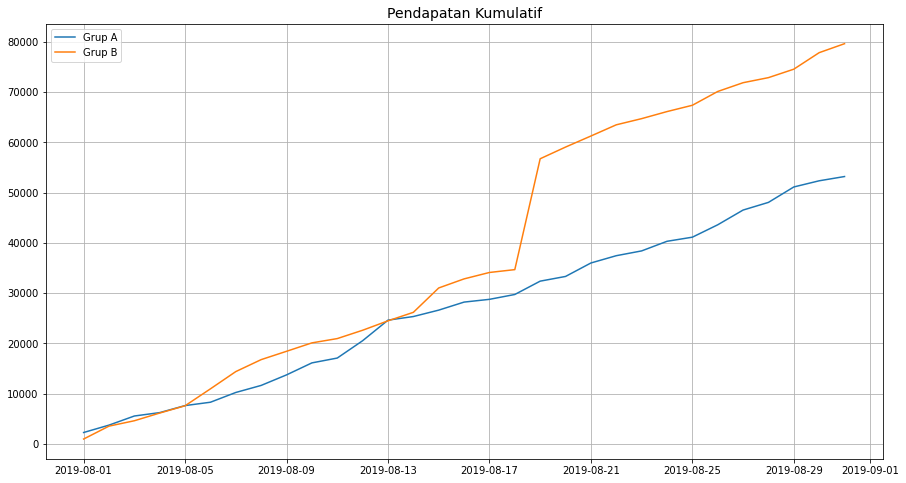

In [28]:
plt.figure(figsize=(15,8)) 
plt.title('Pendapatan Kumulatif', fontsize=14)
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')
plt.legend(['Grup A', 'Grup B'])
plt.grid(True)

plt.show()

Dari grafik dapat terlihat bahwa terjadi kenaikan pendapatan pada masing - masing grup. Pada awalnya tidak ada perbedaan yang signifikan dari grup A dan grup B, namun sekitar tanggal 19 Agustus 2019 terdapat pendapatan pada grup B yang signifikan sehingga menyebabkan perbedaan pendapatan kumulatif antar grup membesar. 

#### Ukuran pesanan rata - rata kumulatif

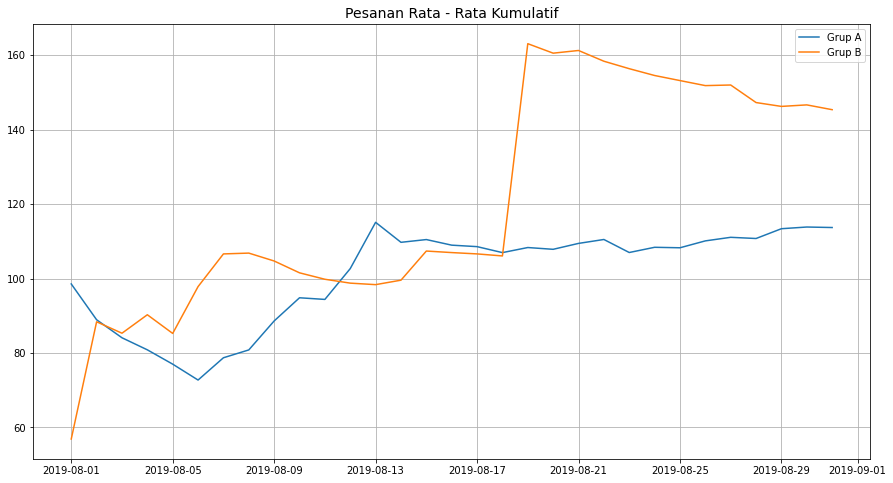

In [29]:
plt.figure(figsize=(15,8)) 
plt.title('Pesanan Rata - Rata Kumulatif', fontsize=14)
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.legend(['Grup A', 'Grup B'])
plt.grid(True)

plt.show()

Dari grafik dapat terlihat bahwa untuk grup A, pesanan rata - rata kumulatif pada awalnya menurun hingga tanggal 6 Agustus 2019, lalu naik hingga puncaknya pada tanggal 13 Agustus 2019, lalu cenderung stabil hingga akhir bulan, dengan tren utama menunjukan adanya kenaikan yang terlihat dari adanya jumlah pesanan rata - rata kumulatif pada akhir bulan lebih tinggi dibandingkan awal bulan. Untuk grup B, pesanan rata - rata kumulatif naik drastis pada tanggal 2 Agustus 2019, lalu stabil dengan cenderung naik hingga tanggal 18 Agustus 2019 lalu terjadi kenaikan drastis kembali pada tanggal 19 Agustus 2019 dan diakhiri dengan stabil dengan cendurung turun. Dapat terlihat bahwa terdapat 2 kali kenaikan drastis pada grup B sedangkan A cenderung naik / turun secara stabil.

#### Perbedaan Relatif untuk Ukuran Pesanan Rata - Rata Kumulatif

Pertama dari kedua tabel diatas akan digabungkan terlebih dahulu

In [30]:
mergedCumulativeRevenue = cumulativeRevenueA.merge(
    cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B']
)
mergedCumulativeRevenue.head()

,date,revenueA,ordersA,revenueB,ordersB
0,2019-08-01,2266.6,23,967.2,17
1,2019-08-02,3734.9,42,3535.3,40
2,2019-08-03,5550.1,66,4606.9,54
3,2019-08-04,6225.6,77,6138.5,68
4,2019-08-05,7623.6,99,7587.8,89


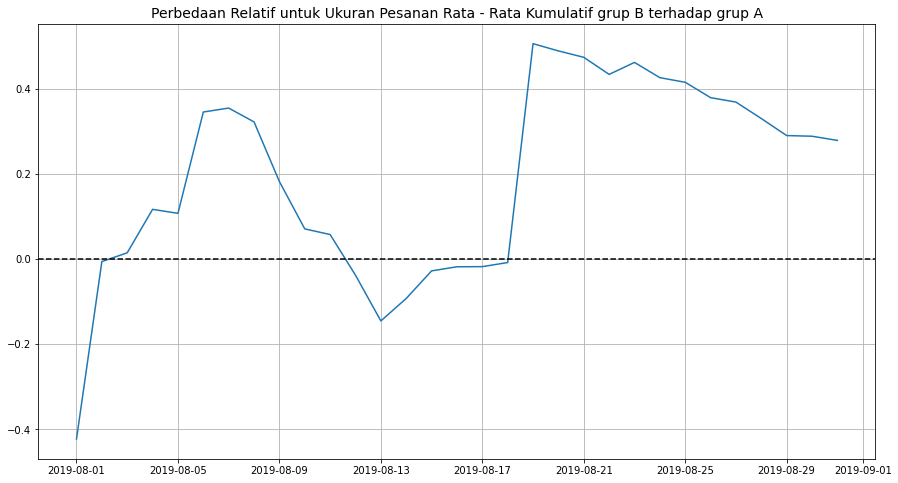

In [31]:
plt.figure(figsize=(15,8)) 
plt.title('Perbedaan Relatif untuk Ukuran Pesanan Rata - Rata Kumulatif grup B terhadap grup A', fontsize=14)
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)
plt.axhline(y=0, color='black', linestyle='--') 
plt.grid(True)

plt.show()

Dari kurva diatas dapat terlihat bahwa pada beberapa waktu grup A menunjukan pesanan rata - rata kumulatif yang lebih besar dibandingkan dengan grup B, namun grup B mendominasi pesanan rata - rata kumulatif, terlihat dengan banyaknya kurva yang condong berada pada sumbu-y positif. Terdapat beberapa titik yang menunjukan adanya kenaikan secara drastis, sehingga besar kemungkinan bahwa titik - titik tersebut merupakan outlier.

#### Tingkat Konversi Harian

Selanjutnya akan dicari tingkat konversi sebagai rasio pesanan terhadap total kunjungan setiap hari. Pertama dari tabel `cumulativeData` akan ditambahkan kolom `conversion`

In [32]:
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']
cumulativeData.head()

,date,group,orders,buyers,revenue,visitors,conversion
0,2019-08-01,A,23,19,2266.6,719,0.031989
1,2019-08-01,B,17,17,967.2,713,0.023843
2,2019-08-02,A,42,36,3734.9,1338,0.031390
3,2019-08-02,B,40,39,3535.3,1294,0.030912
4,2019-08-03,A,66,60,5550.1,1845,0.035772


Selanjutnya akan dibagi menjadi 2 tabel berdasarkan grup dan digambarkan grafik

In [33]:
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

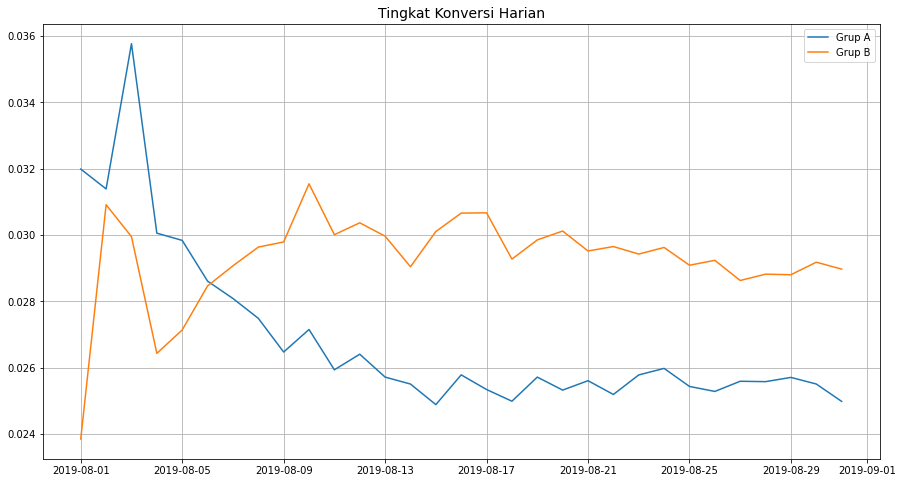

In [34]:
plt.figure(figsize=(15,8)) 
plt.title('Tingkat Konversi Harian', fontsize=14)
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.legend(['Grup A', 'Grup B'])
plt.grid(True)

plt.show()

Dari grafik dapat terlihat bahwa untuk grup A pada sekitar tanggal 3 Agustus 2019 terjadi kenaikan konversi harian yang drastis, namun selanjutnya tingkat konversi hariannya mengalami tren penurunan hingga pada akhirnya stabil. Untuk grup B, sekitar tanggal 2 Agustus 2019 terjadi kenaikan tingkat konversi harian, lalu diikuti oleh penuruan hingga tanggal 4 Agustus 2019 dan selanjutnya diikuti sedikit kenaikan hingga pada akhirnya stabil. Dapat terlihat bahwa tingkat konversi harian grup B lebih tinggi dibandingkan dengan tingkat konversi harian grup A.

#### Jumlah pesanan per pengguna

Pertama dibuat tabel `orders_by_user` yang akan mengelompokan pengunjung dan menghitung jumlah pemesanan.

In [35]:
orders_per_user = orders.groupby('visitor_id')['transaction_id'].count().reset_index()
orders_per_user.columns = ['visitor_id', 'orders']
orders_per_user.head()

,visitor_id,orders
0,5114589,1
1,6958315,1
2,11685486,1
3,39475350,1
4,47206413,1


Lalu dibuat diagram sebar yang menggambarkan jumlah pemesanan per pengguna

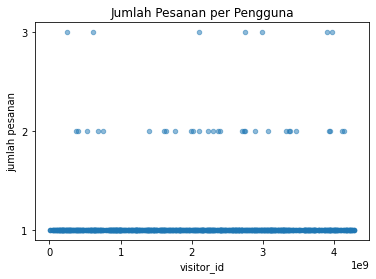

In [36]:
ax = orders_per_user.plot('visitor_id', 'orders', kind='scatter', title='Jumlah Pesanan per Pengguna', alpha = 0.5)
ax.set_xlabel('visitor_id')
ax.set_ylabel('jumlah pesanan')

plt.yticks(range(1, 4))
plt.show()

Dari grafik dapat terlihat bahwa mayoritas pengunjung melakukan 1 pemesanan, dan hanya sedikit yang melakukan 2 dan 3 pemesanan.

#### Persentil ke-95 dan ke-99 untuk Jumlah Pesanan per Pengguna

In [37]:
order_95, order_99 = np.percentile(orders_per_user['orders'], [95, 99])

print(f'95% dari pengguna hanya melakukan pemesanan sebanyak {int(order_95)} buah atau kurang')
print(f'99% dari pengguna hanya melakukan pemesanan sebanyak {int(order_99)} buah atau kurang')

95% dari pengguna hanya melakukan pemesanan sebanyak 1 buah atau kurang
99% dari pengguna hanya melakukan pemesanan sebanyak 2 buah atau kurang


Dapat dilihat bahwa jumlah pesanan diatas 2 buah hanya melambangkan sekitar 1 persen dari keselurhan pengguna. Sehingga dapat disimpulkan bahwa untuk pelanggan dengan jumlah pesanan diatas 2 merupakan data yang anomali.

#### Distribusi Harga Pesanan

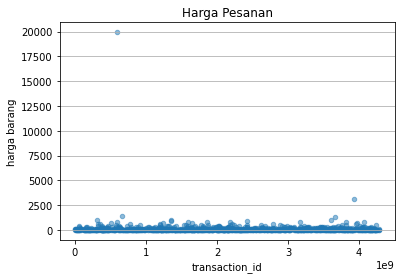

In [38]:
ax = orders.plot('transaction_id', 'revenue', kind='scatter', title='Harga Pesanan', alpha = 0.5)
ax.set_xlabel('transaction_id')
ax.set_ylabel('harga barang')
plt.grid(True, axis='y')

plt.show()

Dari diagram sebar dapat terlihat bahwa mayoritas harga pesanan dibawah 2500, dengan terdapat harga pesanan sebesar 20000.

#### Persentil ke-95 dan ke-99 untuk Harga Pesanan

In [39]:
revenue_95, revenue_99 = np.percentile(orders['revenue'], [95, 99])

print(f'95% dari harga pesanan adalah {revenue_95.round(3)} atau kurang')
print(f'99% dari harga pesanan adalah {revenue_99.round(3)} atau kurang')

95% dari harga pesanan adalah 414.275 atau kurang
99% dari harga pesanan adalah 830.3 atau kurang


Dapat terlihat bahwa 5% dari harga pesanan lebih dari 414,275 dan 1 % dari harga pesanan lebih dari 830,3. Dari sini, harga pesanan diatas 830,3 merupakan nilai anomali

#### Signifikansi Statistik Perbedaan Konversi Antar Kelompok menggunakan Data Mentah

Dengan mengetahui batasan data yang termasuk outlier, maka bisa dilihatan perbedan signifikasi statistik sebelum dan sesudah data mentah dibuang nilai - nilai outlier nya. Pertama dilihat siginifikansi statistik perbedaan konversi antar kelompok menggunakan data mentah, dengan hipotesis nol dan alternatif sebagai berikut:
- H0(hipotesis nol): Tidak ada perbedaan konversi antara grup A dan B 
- H1(hipotesis alternatif): Terdapat perbedaan konversi antara grup A dan B 

In [40]:
ordersByUsersA = orders[orders['group']=='A'].groupby('visitor_id', as_index=False).agg({'transaction_id' : pd.Series.nunique})
ordersByUsersA.columns = ['user_id', 'orders']
ordersByUsersA.head()

,user_id,orders
0,11685486,1
1,54447517,1
2,66685450,1
3,78758296,1
4,85103373,1


In [41]:
ordersByUsersB = orders[orders['group']=='B'].groupby('visitor_id', as_index=False).agg({'transaction_id' : pd.Series.nunique})
ordersByUsersB.columns = ['user_id', 'orders']
ordersByUsersB.head()

,user_id,orders
0,5114589,1
1,6958315,1
2,39475350,1
3,47206413,1
4,48147722,1


In [42]:
sampleA = pd.concat(
    [
        ordersByUsersA['orders'],pd.Series(
            0, index=np.arange(
                visits[visits['group']=='A']['visits'].sum() - len(ordersByUsersA['orders']
                                                                        )
            ), name='orders')
    ],axis=0
)
sampleB = pd.concat(
    [
        ordersByUsersB['orders'],pd.Series(
            0, index=np.arange(
                visits[visits['group']=='B']['visits'].sum() - len(ordersByUsersA['orders']
                                                                        )
            ), name='orders')
    ],axis=0
)
sampleA

0        1
1        1
2        1
3        1
4        1
        ..
18286    0
18287    0
18288    0
18289    0
18290    0
Name: orders, Length: 18736, dtype: int64

In [43]:
print('Nilai batas signifkansi (alpha) = 0,05')
print('Nilai p: {0:.3f}'.format(st.mannwhitneyu(sampleA, sampleB)[1]))
print('Perbedaan relatif konversi: {0:.2f}%'.format((sampleB.mean() / sampleA.mean() - 1) * 100)) 

if (st.mannwhitneyu(sampleA, sampleB)[1] < 0.05):
    print('Kita menolak hipotesis nol')
else:
    print("Kita tidak dapat menolak hipotesis nol")

Nilai batas signifkansi (alpha) = 0,05
Nilai p: 0.013
Perbedaan relatif konversi: 15.47%
Kita menolak hipotesis nol


Nilai p adalah 0,013, dengan nilai p lebih kecil dibandingkan dengan nilai alpha. Sehingga hipotesis nol ditolak dan hipotesis alternatif diterima, yakni terdapat perbedaan konversi antara grup A dan grup B dengan grup B memiliki perbedaan relatif konversi sebesar 15,47% lebih besar dibandingkan dengan grup A

#### Signifikansi Statistik Perbedaan Ukuran Pesanan Rata-Rata Antar Kelompok menggunakan Data Mentah

Selanjutnya akan dicari signifikansi statistik perbedaan ukuran pesanan rata - rata antar kelompok, dengan hipotesis nol dan alternatifnya sebagai berikut:
- H0(hipotesis nol): Tidak ada perbedaan ukuran pesananan rata - rata antar grup A dan grup B
- H1(hipotesis alternatif): Terdapat perbedaan ukuran pesananan rata - rata antar grup A dan grup B

In [44]:
p_value = st.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]
print('Nilai batas signifkansi (alpha) = 0,05')
print('Nilai p: {0:.3f}'.format(p_value))
print('Perbedaan relatif ukuran pesanan rata - rata: {0:.2f}%'.format((orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1)*100 ))

if (p_value < 0.05):
    print('Kita menolak hipotesis nol')
else:
    print("Kita tidak dapat menolak hipotesis nol")

Nilai batas signifkansi (alpha) = 0,05
Nilai p: 0.862
Perbedaan relatif ukuran pesanan rata - rata: 27.83%
Kita tidak dapat menolak hipotesis nol


Nilai p adalah 0,862, yang berarti nilai p lebih besar dibandingkan dengan nilai alpha. Sehingga hipotesis nol tidak dapat ditolak, yakni tidak ada perbedaan ukuran pesanan rata - rata antar grup A dan grup B dengan grup B memiliki rata - rata ukuran pesanan sebesar 27,83% lebih besar dibandingkan dengan grup A.

#### Signifikansi Statistik Perbedaan Konversi Antar Kelompok menggunakan Data yang Telah Difilter

Selanjutnya akan dilihat signifikasi statistik perbedaan konversi antar kelompok namun dengan data yang telah difilter. Seperti yang telah ditulis diatas, pesanan dengan jumlah kunjungan lebih dari 2 atau harga pesanan lebih dari 830,3 merupakan data yang anomali. Untuk Hipotesis nol dan alternatif nya adalah:
- H0(hipotesis nol): Tidak ada perbedaan konversi antara grup A dan B 
- H1(hipotesis alternatif): Terdapat perbedaan konversi antara grup A dan B 

In [45]:
usersWithManyOrders = pd.concat([ordersByUsersA[ordersByUsersA['orders'] > 2]['user_id'], ordersByUsersB[ordersByUsersB['orders'] > 2]['user_id']], axis = 0)
usersWithExpensiveOrders = orders[orders['revenue'] > 830.3]['visitor_id']
abnormalUsers = pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis = 0).drop_duplicates().sort_values()
abnormalUsers.shape

(16,)

Telah ditemukan bahwa terdapat 16 data yang bersifat anomali, selanjutnya akan dilakukan pemfilteran data

In [46]:
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(
                ordersByUsersA['user_id'].isin(abnormalUsers)
            )
        ]['orders'],pd.Series(
            0, index=np.arange(
                visits[
                    visits['group']=='A'
                ]['visits'].sum() - len(ordersByUsersA['orders'])
            ),name='orders')],axis=0)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(
                ordersByUsersB['user_id'].isin(abnormalUsers)
            )
        ]['orders'],pd.Series(
            0, index=np.arange(
                visits[
                    visits['group']=='B'
                ]['visits'].sum() - len(ordersByUsersB['orders'])
            ),name='orders')],axis=0)
sampleAFiltered

0        1
1        1
2        1
3        1
4        1
        ..
18286    0
18287    0
18288    0
18289    0
18290    0
Name: orders, Length: 18726, dtype: int64

In [47]:
print('Nilai batas signifkansi (alpha) = 0,05')
print('Nilai p: {0:.3f}'.format(st.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print('Perbedaan relatif konversi: {0:.2f}%'.format((sampleBFiltered.mean() / sampleAFiltered.mean() - 1) * 100)) 

if (st.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1] < 0.05):
    print('Kita menolak hipotesis nol')
else:
    print("Kita tidak dapat menolak hipotesis nol")

Nilai batas signifkansi (alpha) = 0,05
Nilai p: 0.007
Perbedaan relatif konversi: 18.92%
Kita menolak hipotesis nol


Dengan menggunakan data yang terfilter, didapat bahwa nilai p sama - sama lebih kecil dibandingkan nilai alpha dibandingkan dengan data mentah, sehingga terdapat perbedaan konversi antara grup A dan grup B baik dari data mentah maupun data filter. Namun perbedaan nya adalah perbedaan relatif konversi grup B setelah dilakukan pemfilteran data adalah 18,92% lebih tinggi dibandingkan dengan grup A. Nilai ini lebih tinggi dibandingkan dengan nilai data mentah yang sebesar 15,47%.

#### Signifikansi Statistik Perbedaan Ukuran Pesanan Rata - Rata Antar Kelompok menggunakan Data yang Telah Difilter

Selanjutnya akan dicari signifikansi statistik perbedaan ukuran pesanan rata - rata antar kelompok dengan menggunakan data yang telah difilter, dengan hipotesis nol dan alternatifnya sebagai berikut:
- H0(hipotesis nol): Tidak ada perbedaan ukuran pesananan rata - rata antar grup A dan grup B
- H1(hipotesis alternatif): Terdapat perbedaan ukuran pesananan rata - rata antar grup A dan grup B

In [48]:
p_value=st.mannwhitneyu(
    orders[np.logical_and(
        orders['group']=='A',
        np.logical_not(orders['visitor_id'].isin(abnormalUsers)))]['revenue'],
    orders[np.logical_and(
        orders['group']=='B',
        np.logical_not(orders['visitor_id'].isin(abnormalUsers)))]['revenue'])[1]

print('Nilai batas signifkansi (alpha) = 0,05')
print('Nilai p:{0:.3f}'.format(p_value))

print('Perbedaan relatif ukuran pesanan rata - rata:{0:.2f}%'.format((
    orders[np.logical_and(orders['group']=='B',np.logical_not(orders['visitor_id'].isin(abnormalUsers)))]['revenue'].mean()/
    orders[np.logical_and(
        orders['group']=='A',
        np.logical_not(orders['visitor_id'].isin(abnormalUsers)))]['revenue'].mean() - 1) * 100))

if (p_value < 0.05):
    print('Kita menolak hipotesis nol')
else:
    print("Kita tidak dapat menolak hipotesis nol")

Nilai batas signifkansi (alpha) = 0,05
Nilai p:0.822
Perbedaan relatif ukuran pesanan rata - rata:-3.19%
Kita tidak dapat menolak hipotesis nol


Dengan menggunakan data yang terfilter, dapat dilihat bahwa tidak ada nilai p lebih tinggi dibandingkan nilai alpha, sehingga hipotesis nol tidak dapat ditolak, sama seperti dengan data mentah. Artinya tidak ada perbedaan ukuran pesanan rata - rata antar grup A dan grup B. Namun yang menjadikan perbedaan adalah nilai perbedaan relatif ukuran pesanan rata - rata. Dengan menggunakan data mentah, grup B memiliki perbedaan 27,83% lebih besar dibandingkan dengan grup A, namun dengan menggunakan data yang telah difilter, grup B memiliki perbedaan 3,19% lebih kecil dibandingkan dengan grup A.

#### Penutup: Keputusan berdasarkan Hasil Pengujian

Dari hasil pengujian bisa didapatkan keputusan yakni:
1. Menghentikan pengujian, serta mempertimbangkan salah satu kelompok sebagai pemimpin
2. Menghentikan pengujian, serta menyimpulkan bahwa tidak ada perbedaan antara kedua kelompok
3. Melanjutkan pengujian

Walaupun dari hasil perbedaan ukuran rata - rata pesanan antara grup A dan grup B tidak terdapat perbedaan, dengan data yang telah difilter dari anomali menunjukan perubahan yang signifikan dengan grup A yang memiliki ukuran pesanan lebih besar dibandingkan dengan data mentah, namun hasil dari perbedaan konversi antara grup A dengan grup B menunjukan bahwa grup B memiliki perbedaan relatif konversi yang lebih tinggi dibandingkan dengan grup A, bahkan setelah dilakukan pemfilteran nilai perbedaan ini menjadi lebih besar. Sehingga didapat kesimpulan bahwa diambil keputusan pertama, yakni menghentikan pengujian dan menyatakan bahwa grup B sebagai pemimpin dilihat dari konversi. 

## Kesimpulan

Dari kegiatan ini diperoleh berbagai kesimpulan:
- Dari prioritas hipotesis berdasarkan framework RICE, menambah form berlangganan menjadi hipotesis yang paling menjanjikan, diikuti oleh menambah rekomendasi produk dan 2 channel baru. Walaupun dari hasil framework ICE, hipotesis memberikan diskon pada hari ulang tahun pelanggan adalah hipotesis dengan urutan pertama, namun setelah dikonversi dengan framework RICE, hipotesis ini menjadi hipotesis dengan urutan kelima tertinggi, hal ini disebabkan karena nilai Reach nya sangat kecil, hanya bernilai 1.
- Dari A/B testing, didapat kesimpulan bahwa pengujian A/B testing telah cukup, dengan grup B adalah grup yang memberikan hasil yang lebih baik dibandingkan grup A. Hal ini disebabkan karena dari sisi konversi, grup B memberikan nilai konversi lebih besar dibandingkan grup A, baik menggunakan data mentah maupun menggunakan data yang telah difilter.